## Entrenamiento de ResNet50 con data augmentation y 3 modelos

Se procede al particionado de datos de train y valid por separado para aplicar data augmentation en entrenamiento mediante la librería imgaug. Luego, se proceden a realizar un modelo de clasificación binaria para discriminar primero el tipo de enfermedad, y posteriormente, se creará un modelo específico para enfermedades cancerígenas y no cancerígenas.

Comenzamos por la importación de librerías

In [27]:
# Librerías utilizadas por el script
import timm
import numpy as np
import pandas as pd
import cv2
import torch
import fastbook
import fastai
import fastcore
import PIL

import matplotlib.pyplot as plt
import imgaug as ia
import seaborn as sns

from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from fastai.vision.all import *
from nbdev.showdoc import *
from fastai.vision.all import *

"""
!pip install -Uqq fastbook
!pip install nbdev
"""
fastbook.setup_book()
torch.cuda.is_available()

True

A continuación, se declaran las constantes usadas como parámetros a las funciones

In [28]:
# Número de clases. 2 para la binaria.
NUM_CLASSES = 2
TRAIN_DIR = "trainThumbnails/"
VALID_PCT = 0.3
SEED = 19
# Número de canales de cada imagen
CHANNELS = 3
IMAGE_RESIZE = 386
RESIZE_METHOD = 'squish'
LOSS_FUNC = CrossEntropyLossFlat()
METRICS = [accuracy, BalancedAccuracy(), error_rate, Recall(), Precision()]

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 3

BATCH_SIZE = 16

train_df = pd.read_csv('trainSet.csv',index_col=0)
np.random.seed(SEED)

Realizamos la seperación de entrenamiento y validación, junto el aumento de datos. Primero, se separa el entrenamiento para evitar un sesgo de los resultados en validación, y posteriormente, se procede a la construcción de los dataframes.

bin
Benign       50949
Malignant    13932
Name: count, dtype: int64


<Axes: xlabel='bin', ylabel='count'>

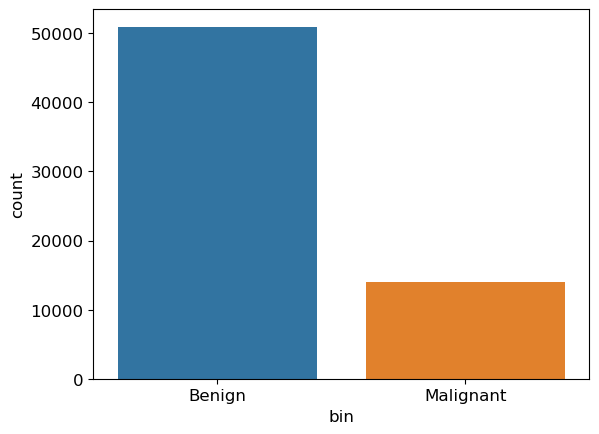

In [29]:
# Separación validación y train

#train, valid = train_test_split(train_df, test_size=VALID_PCT,stratify=train_df[['bin']])

# Vemos cómo es el desequilibrio entre clases
print(train_df.bin.value_counts())

sns.countplot(data=train_df, x='bin', order=train_df.bin.value_counts().index)



In [30]:
 # Hallamos cuál es la proporción entre las dos clases para igualarlas mediante aumento de datos
benign_count, malign_count = train_df.bin.value_counts()
print("MAL/BENG: ", benign_count/malign_count)

MAL/BENG:  3.6569767441860463


Podemos generar hasta 3 imágenes por data augmentation de la clase maligna para equiparar aproximadamente ambas clases

In [31]:
if not os.path.isdir(TRAIN_DIR):
    print('%s is not a valid directory.' % TRAIN_DIR)
    sys.exit(1)
    
IMG_EXTENSION = ".png"
NUM_AUG_IMAGES_BEN = 1
NUM_AUG_IMAGES_MAL = 5
debug = False
cwd = os.getcwd()

#### Define augmentation sequence ####
# See https://github.com/aleju/imgaug for a list of augmentation techniques available.
seq = iaa.Sequential([
    iaa.Fliplr(0.5),                             # Horizontal flip 50% of images
    iaa.Crop(percent=(0, 0.10)),                 # Crop all images between 0% to 10%
    iaa.GaussianBlur(sigma=(0, 1)),              # Add slight blur to images
    iaa.AddToBrightness((-30, 30)),             # Slightly brighten, darken, or recolor images
    iaa.Affine(
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # Translate image
        rotate=(-5, 5),                                         # Rotate image
        mode=ia.ALL, cval=(0,255)                               # Filling in extra pixels
        )
    ])


#img_ben = train.loc[train['bin'] == "Benign"]['image'].to_list()
#img_mal = train.loc[train['bin'] == "Malignant"]['image'].to_list()

Comprobamos que el formato es el adecuado

In [32]:
# Le añadimos el directorio
"""
for i in range(len(img_ben)):
    img_ben[i] = TRAIN_DIR + img_ben[i]

for i in range(len(img_mal)):
    img_mal[i] = TRAIN_DIR + img_mal[i]
"""

'\nfor i in range(len(img_ben)):\n    img_ben[i] = TRAIN_DIR + img_ben[i]\n\nfor i in range(len(img_mal)):\n    img_mal[i] = TRAIN_DIR + img_mal[i]\n'

Ahora, podemos realizar data augmentation de ambas clases. El hecho de hacerlo por separado se debe a que aumentaremos en mayor medida los casos malignos que los benignos para así equiparar el recuento. Multimplicaremos beningnos por 2, y malignos por 6, para así aproximar ambas clases

In [33]:

# Go through every image in directory, augment it, and save new image/annotation data

def data_aug(img_list, num_img, out_df, direct):
    img_aug_list = []
    for img_fn in img_list:

        #---- Load image ----#
        img1_bgr = cv2.imread(img_fn) # Load image with OpenCV
        img1 = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB) # Re-color to RGB from BGR

        #---- Augment image N times----#
        for i in range(num_img):
            img_aug1 = seq1(images=[img1])[0] # Apply augmentation to image

            #---- Save image ----#
            base_fn = img_fn[:-4] # Get image base filename
            img_aug_fn = base_fn + ('_aug%d' % (i+1)) + IMG_EXTENSION # Append "aug#" to filename
            img_aug_bgr1 = cv2.cvtColor(img_aug1, cv2.COLOR_RGB2BGR) # Re-color to BGR from RGB
            
            # Añadimos al dataframe, convirtiendo previamente en una lista para fácil edición
            el = out_df.loc[out_df['image'] == img_fn.split("/")[1]].values.flatten().tolist()
            el[0] = img_aug_fn.split("/")[1]
            el[1] = img_aug_fn
            
            img_aug_list.append(el)

            cv2.imwrite(direct + img_aug_fn.split("/")[1],img_aug_bgr1) # Save image to disk
            
    #print(img_aug_list)
    img_aug_df = (pd.DataFrame(img_aug_list, columns=list(out_df.columns)))
    out_df = pd.concat([out_df, img_aug_df], ignore_index=True)
        
    return out_df
    

In [34]:
"""
train_aug = train.copy()
train_aug = data_aug(img_ben, 1,train_aug, "binAUG/")
train_aug = data_aug(img_mal, 5,train_aug, "binAUG/")
"""

'\ntrain_aug = train.copy()\ntrain_aug = data_aug(img_ben, 1,train_aug, "binAUG/")\ntrain_aug = data_aug(img_mal, 5,train_aug, "binAUG/")\n'

Leemos el dataframe con la información asoaciada a las etiquetas y otros metadatos

In [35]:
display(train_df)

,image,dir,label,dataset,bin
0,ASAN_8196.png,datasets/Asan/dataset/hemangioma/ASAN_8196.png,hemangioma,ASAN,Benign
1,ASAN_10059.png,datasets/Asan/dataset/dermatofibroma/ASAN_10059.png,dermatofibroma,ASAN,Benign
2,SEV_248_74.png,datasets/Severance/thumbnails/SEV_248_74.png,pyogenic_granuloma,SEVERANCE,Benign
3,ISIC_0068761.JPG,datasets/ISIC/Melanoma/ISIC_0068761.JPG,melanoma,ISIC,Malignant
4,SEV_062_17.png,datasets/Severance/thumbnails/SEV_062_17.png,squamous_cell_carcinoma,SEVERANCE,Malignant
...,...,...,...,...,...
64876,ISIC_0014898.JPG,datasets/ISIC/Nevus/ISIC_0014898.JPG,nevus,ISIC,Benign
64877,SEV_345_42.png,datasets/Severance/thumbnails/SEV_345_42.png,syringoma,SEVERANCE,Benign
64878,ISIC_0062505.JPG,datasets/ISIC/Melanoma/ISIC_0062505.JPG,melanoma,ISIC,Malignant
64879,SEV_164_8.png,datasets/Severance/thumbnails/SEV_164_8.png,hemangioma,SEVERANCE,Benign


Creamos el dataset. Para ello, me ayudaré de fastai y crearé un conjunto de imágenes que se usarán para train y test. Nota: hay dos columnas de etiquetas, por lo que se han hecho dos funciones distintas; una que se ocupa de las etiquetas binarias, y otra de las subcategorías. Comenzaremos primero por clasificación binaria.

In [36]:
def binary_label(fname):
    global train_df
    el = train_df.loc[train_df['image'] == str(fname).split("/")[1]]
    return el['bin'].values[0]


def multi_label(fname):
    global train_df
    el = train_df.loc[train_df['image'] == str(fname)]
    return ((el['label'].values[0]))

Aplicamos las transformaciones de img aug de forma personalizada, haciendo un wrapper para el argumento transformaciones.

In [37]:
# Crear una función de transformación personalizada utilizando imgaug
def imgaug_transformations(x: PIL.Image.Image):
    seq = iaa.Sequential([
    iaa.Fliplr(0.5),                             # Horizontal flip 50% of images
    iaa.Crop(percent=(0, 0.10)),                 # Crop all images between 0% to 10%
    iaa.GaussianBlur(sigma=(0, 1)),              # Add slight blur to images
    iaa.AddToBrightness((-30, 30)),             # Slightly brighten, darken, or recolor images
    iaa.Affine(
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # Translate image
        rotate=(-5, 5),                                         # Rotate image
        mode=ia.ALL, cval=(0,255)                               # Filling in extra pixels
        )
    ])

    img_arr = np.array(x)
    augmented_img_arr = seq.augment_image(img_arr)
    return PIL.Image.fromarray(augmented_img_arr)

# Crear un objeto de transformación en fastai
imgaug_tfm = Transform(imgaug_transformations)

In [38]:
trainSet = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # La entrada es un bloque de imagenes, y la salida, categorias
    get_items=get_image_files,  # Utilizamos el mñetodo get_image_files proporcionado en el Notebook
    splitter=RandomSplitter(valid_pct=VALID_PCT, seed=SEED),  # Establecida semilla 0
    get_y=binary_label,  # Las etiquetas son especificadas como contenido del dataset en si
    item_tfms=[Resize(IMAGE_RESIZE, method=RESIZE_METHOD)],  # Redimensionado
    batch_tfms=[Normalize.from_stats(*imagenet_stats),imgaug_tfm]
).dataloaders(TRAIN_DIR, bs=BATCH_SIZE)

In [39]:
resnet50 = vision_learner(trainSet, 'resnet50', loss_func=LOSS_FUNC, metrics=METRICS,
                          pretrained=True)
print(resnet50.summary())

/home/cristhian/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853099/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Sequential (Input shape: 16 x 3 x 386 x 386)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 193 x 193 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 97 x 97   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                  

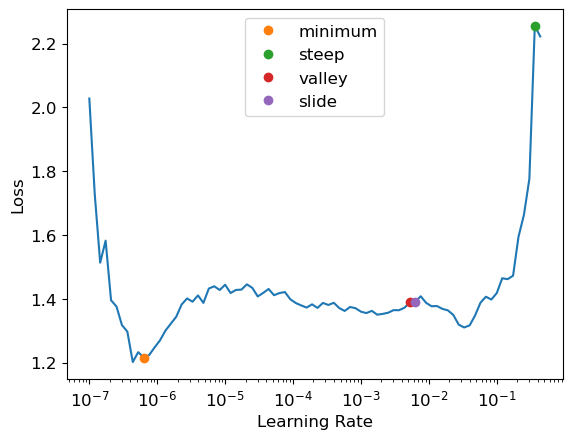

In [40]:
lrs = resnet50.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [41]:
print(trainSet.vocab)

['Benign', 'Malignant']


In [42]:
early_stopping = EarlyStoppingCallback(monitor='valid_loss', patience=EARLY_STOP_PATIENCE)
save_callback = SaveModelCallback(monitor='valid_loss', fname='best_model')

resnet50.fine_tune(NUM_EPOCHS, lrs[2],
                   cbs=[early_stopping, save_callback])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,error_rate,recall_score,precision_score,time
0,0.478788,0.445818,0.798500,0.575220,0.201500,0.181710,0.615942,06:53


Better model found at epoch 0 with valid_loss value: 0.44581764936447144.


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,error_rate,recall_score,precision_score,time
0,0.412533,0.380668,0.827425,0.653263,0.172575,0.346318,0.706053,08:45
1,0.373019,0.378933,0.827014,0.640017,0.172986,0.310451,0.738001,08:41
2,0.398761,0.365668,0.834053,0.682513,0.165947,0.415439,0.694599,08:32
3,0.356074,0.365302,0.834720,0.675630,0.165279,0.395249,0.712634,08:34
4,0.357760,0.365624,0.834926,0.656329,0.165074,0.341568,0.765301,08:40
5,0.370220,0.352662,0.841091,0.713574,0.158909,0.488836,0.686229,07:50
6,0.369169,0.359601,0.841399,0.714114,0.158600,0.489786,0.687104,08:56
7,0.377817,0.359447,0.844739,0.699907,0.155261,0.444656,0.732394,09:21
8,0.354759,0.348329,0.847976,0.714956,0.152024,0.480523,0.723792,09:20
9,0.353970,0.337252,0.849363,0.716185,0.150637,0.481473,0.730187,09:24


Better model found at epoch 0 with valid_loss value: 0.38066762685775757.
Better model found at epoch 1 with valid_loss value: 0.37893256545066833.
Better model found at epoch 2 with valid_loss value: 0.3656682074069977.
Better model found at epoch 3 with valid_loss value: 0.36530229449272156.
Better model found at epoch 5 with valid_loss value: 0.3526623547077179.
Better model found at epoch 8 with valid_loss value: 0.3483293652534485.
Better model found at epoch 9 with valid_loss value: 0.3372517228126526.
Better model found at epoch 12 with valid_loss value: 0.3360438048839569.
Better model found at epoch 13 with valid_loss value: 0.32801568508148193.
Better model found at epoch 15 with valid_loss value: 0.32774215936660767.
No improvement since epoch 15: early stopping


In [43]:
resnet50.summary()

Sequential (Input shape: 16 x 3 x 386 x 386)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 193 x 193 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 97 x 97   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                  

In [44]:
state = torch.load('models/best_model.pth')
preds, targets = resnet50.get_preds(ds_idx=1)  # ds_idx=1 para el conjunto de validación


In [45]:
y_true = targets.numpy()
y_pred = preds.argmax(dim=1).numpy()  # Convierte las probabilidades en etiquetas predichas

In [46]:
print(classification_report(y_true, y_pred, target_names=trainSet.vocab))

              precision    recall  f1-score   support

      Benign       0.90      0.91      0.91     15254
   Malignant       0.67      0.64      0.66      4210

    accuracy                           0.85     19464
   macro avg       0.79      0.78      0.78     19464
weighted avg       0.85      0.85      0.85     19464



In [47]:
torch.save(resnet50, 'modeloentero.pth')

## ONNX

Convertimos al formato estándar

In [48]:
resnet50.export()
resnet50.path

Path('.')

In [49]:
testmodel = torch.load('export.pkl')
model_dict = testmodel.state_dict()
torch.save(model_dict, 'miModelo.pth')

In [50]:
loaded_model = models.resnet50
loaded_model = vision_learner(trainSet, 'resnet50', loss_func=LOSS_FUNC,
                              metrics=METRICS)  # Crea un modelo vacío con la misma arquitectura
loaded_model.load_state_dict(torch.load('miModelo.pth'))

<All keys matched successfully>

In [51]:
type(loaded_model)

fastai.learner.Learner

In [52]:
class InferenceWrapper(nn.Module):
    def __init__(self, model, normalize_mean, normalize_std, scale_inp=False, channels_last=False):
        super().__init__()
        self.model = model
        self.register_buffer("normalize_mean", normalize_mean)
        self.register_buffer("normalize_std", normalize_std)
        self.scale_inp = scale_inp
        self.channels_last = channels_last
        self.softmax = nn.Softmax(dim=1)

    def preprocess_input(self, x):
        if self.scale_inp:
            x = x / 255.0

        if self.channels_last:
            x = x.permute(0, 3, 1, 2)

        x = (x - self.normalize_mean) / self.normalize_std
        return x

    def forward(self, x):
        x = self.preprocess_input(x)
        x = self.model(x)
        x = self.softmax(x)
        return x

In [53]:
# Define the normalization mean and standard deviation
"""mean_tensor = torch.tensor(imagenet_stats[0]).view(1, 3, 1, 1)
std_tensor = torch.tensor(imagenet_stats[1]).view(1, 3, 1, 1)

# Set the model to evaluation mode
resnet50.eval()

# Wrap the model with preprocessing and post-processing steps
wrapped_model = InferenceWrapper(model,
                                 mean_tensor,
                                 std_tensor,
                                 scale_inp=False,  # Scale input values from the rang [0,255] to [0,1]
                                 channels_last=False,  # Have the model expect input in channels-last format
                                 )"""

'mean_tensor = torch.tensor(imagenet_stats[0]).view(1, 3, 1, 1)\nstd_tensor = torch.tensor(imagenet_stats[1]).view(1, 3, 1, 1)\n\n# Set the model to evaluation mode\nresnet50.eval()\n\n# Wrap the model with preprocessing and post-processing steps\nwrapped_model = InferenceWrapper(model,\n                                 mean_tensor,\n                                 std_tensor,\n                                 scale_inp=False,  # Scale input values from the rang [0,255] to [0,1]\n                                 channels_last=False,  # Have the model expect input in channels-last format\n                                 )'

In [54]:
resnet50.load('best_model')

/home/cristhian/anaconda3/lib/python3.11/site-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


In [55]:
import torch
import torchvision
import torchvision.transforms as transforms

# https://pytorch.org/vision/stable/models.html

pytorch_model = resnet50.model.eval()  # gets the PyTorch model
softmax_layer = torch.nn.Softmax(dim=1)  # define softmax
normalization_layer = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])  # normalization layer

# assembling the final model
final_model = nn.Sequential(
    normalization_layer,
    pytorch_model,
    softmax_layer
)

In [56]:
input = torch.randn(BATCH_SIZE, 3, IMAGE_RESIZE, IMAGE_RESIZE).to('cuda')
torch.onnx.export(
    final_model,
    input,
    'modelbase.onnx',
    do_constant_folding=True,
    export_params=True,
    input_names=['input'],
    output_names=['output'],
    opset_version=17,
    dynamic_axes={'input': {0: 'batch_size'},  # variable length axes
                  'output': {0: 'batch_size'}}
)

Inferimos en ONNX

In [57]:
from PIL import Image


def image_transform_onnx(path: str, size: int) -> np.ndarray:
    '''Image transform helper for onnx runtime inference.'''

    image = Image.open(path)
    image = image.resize((size, size))

    # now our image is represented by 3 layers - Red, Green, Blue
    # each layer has a 224 x 224 values representing
    image = np.array(image)

    # dummy input for the model at export - torch.randn(1, 3, 224, 224)
    image = image.transpose(2, 0, 1).astype(np.float32)

    # our image is currently represented by values ranging between 0-255
    # we need to convert these values to 0.0-1.0 - those are the values that are expected by our model
    image /= 255
    image = image[None, ...]
    return image

In [59]:
import numpy as np
import onnxruntime as rt

labels = ['Benign', 'Malignant']

# get image as tensor - 1 x 3 x 256 x 256 dimensions
img = image_transform_onnx('trainThumbnails/ISIC_0068761.JPG', 386)

# initialize onnx runtime inference session
sess = rt.InferenceSession('modelbase.onnx')

# input & output names
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

# input dimensions (important for debugging)
input_dims = sess.get_inputs()[0].shape

print(f"Input layer name: {input_name}, Output layer name: {output_name}, Input Dimension: {input_dims}")

results = sess.run([output_name], {input_name: img})[0]
print(f"It's a {labels[np.argmax(results)]}", results)

Input layer name: input, Output layer name: output, Input Dimension: ['batch_size', 3, 386, 386]
It's a Malignant [[0.05531159 0.9446884 ]]
